We are training on cuda:0 for this experiment


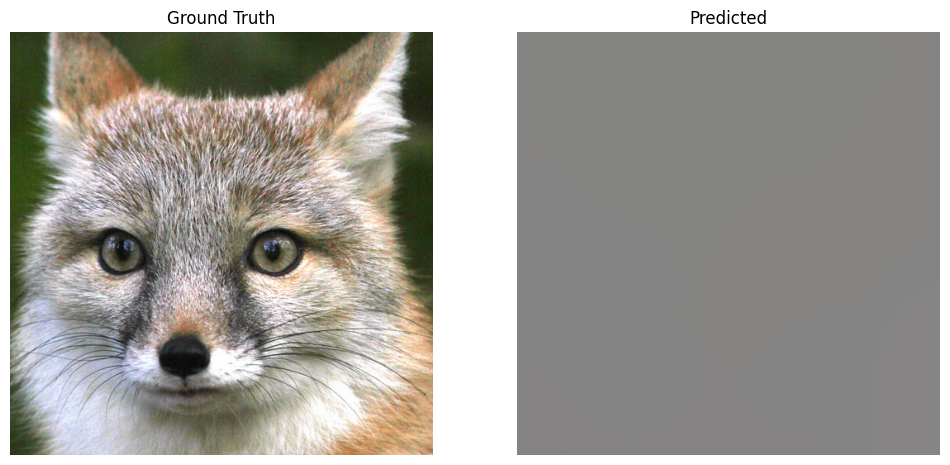

epoch:0 loss:0.06322126090526581
epoch:100 loss:0.05286049097776413
epoch:200 loss:0.051250018179416656
epoch:300 loss:0.048772841691970825
epoch:400 loss:0.04346980154514313
epoch:500 loss:0.03540024161338806
epoch:600 loss:0.0303603857755661
epoch:700 loss:0.027899708598852158
epoch:800 loss:0.026479369029402733
epoch:900 loss:0.025519419461488724


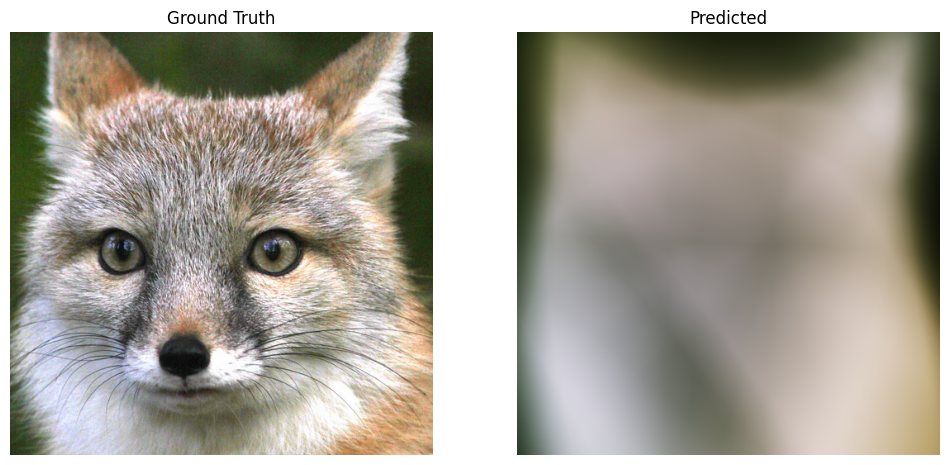

epoch:1000 loss:0.024796530604362488
epoch:1100 loss:0.024183165282011032
epoch:1200 loss:0.023675670847296715
epoch:1300 loss:0.023339157924056053
epoch:1400 loss:0.022814050316810608
epoch:1500 loss:0.02243337407708168
epoch:1600 loss:0.02209862694144249
epoch:1700 loss:0.021783282980322838
epoch:1800 loss:0.02148621901869774
epoch:1900 loss:0.02131408452987671


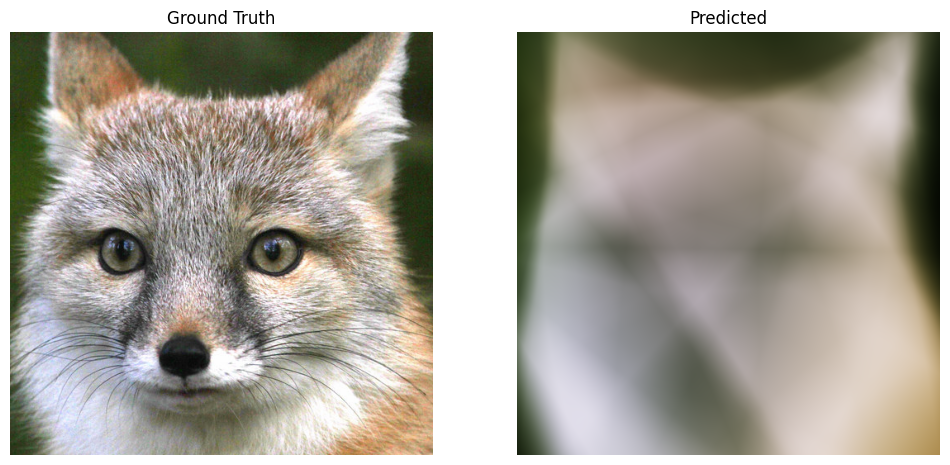

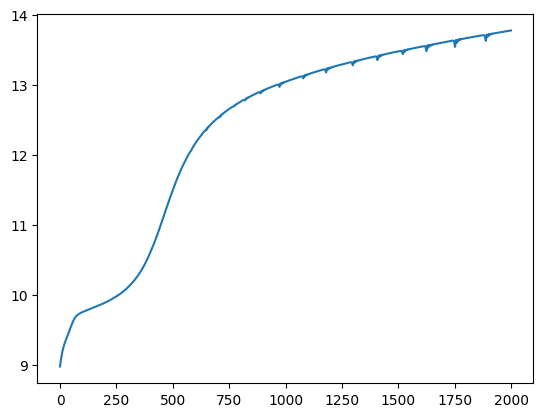

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(f"We are training on {device} for this experiment")

def load_image(path):
    img = torchvision.io.read_image(path)
    # [C, H, W] -> [H, W, C]
    img = img.permute(1,2,0)[..., :3]/255.0
    return img
def display_image(img, pred_img):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title('Ground Truth')
    ax[0].axis('off')
    ax[1].imshow(pred_img)
    ax[1].set_title('Predicted')
    ax[1].axis('off')
    plt.show()

img = load_image('./image.jpg')

h,w = img.shape[0]//2,img.shape[1]//2
img = img[h-256:h+256,w-256:w+256,:3]

# display_image(img,imgc)
# print(imgc.shape)

# Get image dimensions
h,w,c = img.shape
coords = np.zeros((h*w,2),dtype=np.float32)
for i in range(h):
    for j in range(w):
        coords[h*i+j] = [i,j]

target = np.zeros((h*w,c),dtype=np.float32)
for i in range(h):
    for j in range(w):
        target[h*i+j] = img[i][j]

test_input = torch.tensor(coords,dtype=torch.float32)/512.0
test_y = torch.tensor(target,dtype=torch.float32)

# Train set: downsampled by factor of 2
train_input = torch.FloatTensor(test_input[::2].reshape(-1, 2))
train_y = torch.FloatTensor(test_y[::2].reshape(-1, c))

# print(test_input.shape)
import torch.nn as nn
import torch.nn.functional as F

m = 2
n = 3

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(m,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,256)
        self.fc4 = nn.Linear(256,n)
        self.relu = nn.ReLU()
        self.sg = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sg(self.fc4(x))
        return x

model = NeuralNetwork().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Snippet to compute PSNR
def psnr(pred, target):
    return -10 * torch.log10(2.*criterion(pred, target))

start_epoch = 0

train_psnrs = []
test_psnrs = []
best_psnr = 0

# checkpoint = torch.load('./checkpoint.pth')
# start_epoch = checkpoint['epoch']+1
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

end_epoch = start_epoch + 2000

for epoch in range(start_epoch,end_epoch):
    train_input = train_input.to(device)
    train_y = train_y.to(device)

    optimizer.zero_grad()
    outputs = model(train_input)
    loss = criterion(outputs,train_y)
    loss.backward()

    with torch.no_grad():
        test_input = test_input.to(device)
        test_y = test_y.to(device)
        train_psnrs.append(psnr(model(train_input), train_y).cpu().numpy())
        test_psnrs.append(psnr(model(test_input), test_y).cpu().numpy())

        if epoch % 999 == 0:
            pred_img = model(test_input).reshape(img.shape[0],img.shape[1],3).cpu().numpy()
            display_image(img, pred_img)

    optimizer.step()
    if epoch % 100 == 0:
        print(f'epoch:{epoch} loss:{loss}')

#Save model as checkpoint
torch.save(
    {'epoch':end_epoch-1,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict()
     },
     './checkpoint.pth')

# Plot PSNR vs iteration curve
if end_epoch > start_epoch:
    plt.plot(range(start_epoch,end_epoch), train_psnrs)
    plt.show()

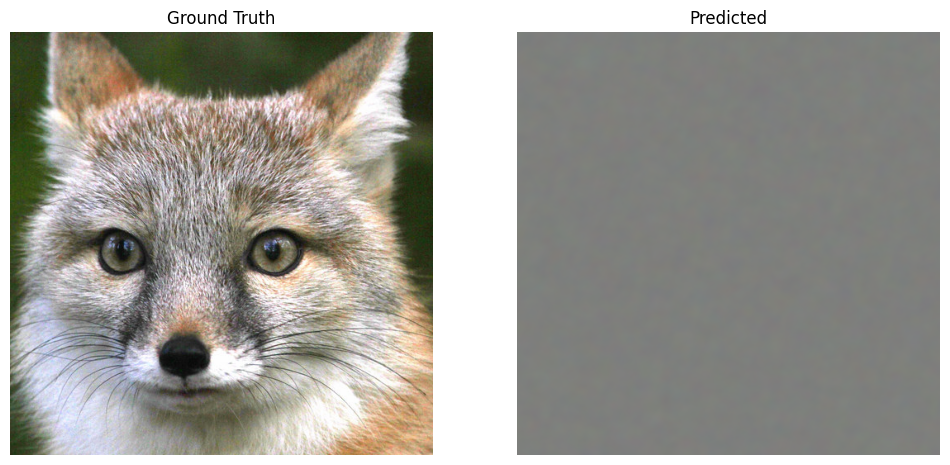

epoch:0 loss:0.06589949131011963
epoch:100 loss:0.01811448112130165
epoch:200 loss:0.006250524893403053
epoch:300 loss:0.005064336583018303
epoch:400 loss:0.004417441785335541
epoch:500 loss:0.0038992101326584816
epoch:600 loss:0.00342547707259655
epoch:700 loss:0.0030148103833198547
epoch:800 loss:0.002686298917979002
epoch:900 loss:0.0024300809018313885


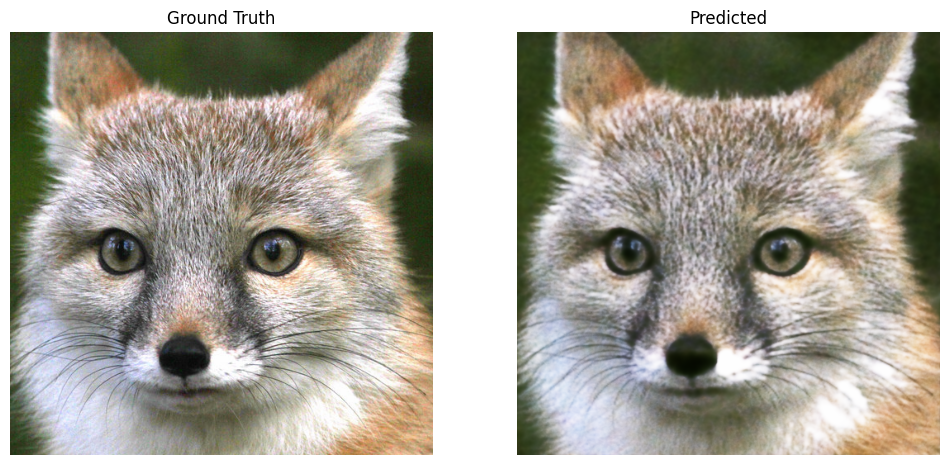

epoch:1000 loss:0.0022204986307770014
epoch:1100 loss:0.0020502328407019377
epoch:1200 loss:0.0019683975260704756
epoch:1300 loss:0.001784634543582797
epoch:1400 loss:0.0016807997599244118
epoch:1500 loss:0.0015949010848999023
epoch:1600 loss:0.001558891381137073
epoch:1700 loss:0.0015039801364764571
epoch:1800 loss:0.0015042093582451344
epoch:1900 loss:0.0013476595049723983


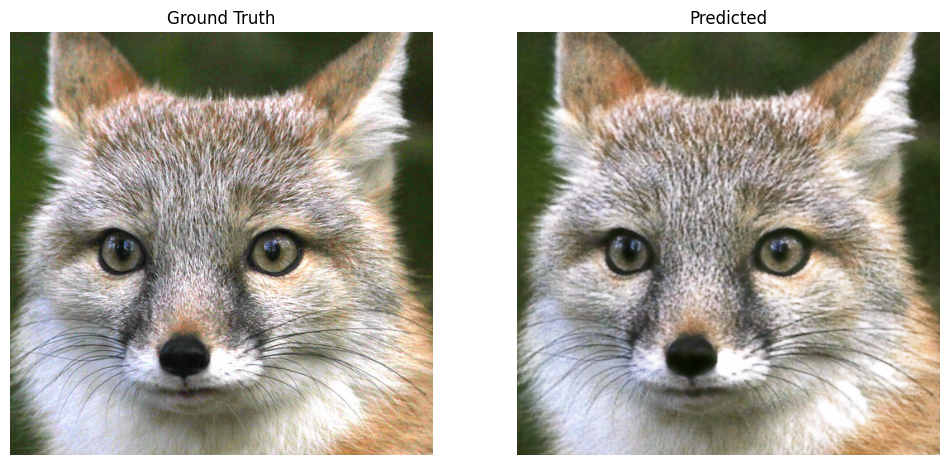

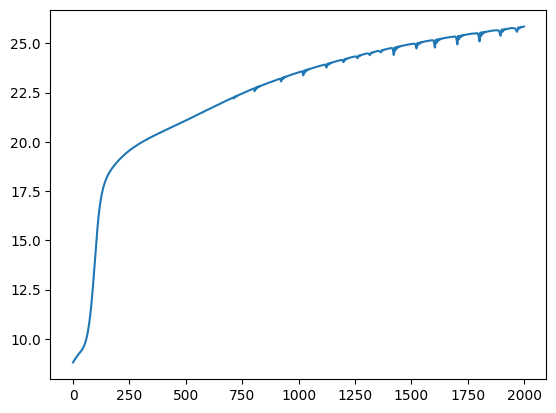

In [ ]:
# Get image dimensions
h,w,c = img.shape
coords = np.zeros((h*w,2),dtype=np.float32)
for i in range(h):
	for j in range(w):
		coords[h*i+j] = [i,j]

target = np.zeros((h*w,c),dtype=np.float32)
for i in range(h):
	for j in range(w):
		target[h*i+j] = img[i][j]

test_input = torch.tensor(coords,dtype=torch.float32,device=device)/512.0
test_y = torch.tensor(target,dtype=torch.float32,device=device)

import math
d = 256
s = 10
B = torch.randn(d,2,device=device) * s
x = torch.sin(2*torch.tensor(math.pi,device=device)*torch.mm(test_input,torch.transpose(B,0,1)))
y = torch.cos(2*torch.tensor(math.pi,device=device)*torch.mm(test_input,torch.transpose(B,0,1)))
gamma = torch.cat((x,y),1)

test_input = gamma
train_input = test_input[::2].reshape(-1, 2*d).type(torch.FloatTensor).to(device)
train_y = test_y[::2].reshape(-1, c).type(torch.FloatTensor).to(device)

import torch.nn as nn
import torch.nn.functional as F

m = 2*d
n = 3
model = NeuralNetwork().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

start_epoch = 0

train_psnrs = []
test_psnrs = []
best_psnr = 0

# checkpoint = torch.load('./checkpoint2.pth')
# start_epoch = checkpoint['epoch']+1
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

end_epoch = start_epoch + 2000

for epoch in range(start_epoch,end_epoch):

    train_input = train_input.to(device)
    train_y = train_y.to(device)

    optimizer.zero_grad()
    outputs = model(train_input)
    loss = criterion(outputs,train_y)
    loss.backward()

    with torch.no_grad():
        test_input = test_input.to(device)
        test_y = test_y.to(device)
        train_psnrs.append(psnr(model(train_input), train_y).cpu().numpy())

        if epoch % 999 == 0:
            pred_img = model(test_input).reshape(img.shape[0],img.shape[1],3).cpu().numpy()
            display_image(img, pred_img)

    optimizer.step()
    if epoch % 100 == 0:
      print(f'epoch:{epoch} loss:{loss}')


#Save model as checkpoint
torch.save(
    {'epoch':end_epoch-1,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict()
     },
     './checkpoint2.pth')

# Plot PSNR vs iteration curve
if end_epoch > start_epoch:
    plt.plot(range(start_epoch,end_epoch), train_psnrs)
    plt.show()